# Text Preprocessing

In [1]:
import dask.dataframe as ddf
import pandas as pd
import numpy as np
import spacy as sp
import time, re, os

from datetime import datetime

# !pip install pysentimiento
from pysentimiento.preprocessing import preprocess_tweet

import warnings
warnings.filterwarnings('ignore')

/Users/jianhongxu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jianhongxu/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Preprocess tweet
def helper_preprocess(text,demojiFlag):
  return preprocess_tweet(text,lang='en', user_token='@usuario',
                          url_token='url',preprocess_hashtags=True,
                          hashtag_token=None,demoji=demojiFlag,
                          shorten=3, normalize_laughter=True,
                          emoji_wrapper='emoji')

In [13]:
# Remove punctuation
def removePunctuation(text):
  punctuationStr= r'[_━🇧.▪"\[!"#\$%&\(\)\*\+,-\./:;<=>\?\^`{\|}~¿¡¬‘’£¥€¢₩°«»“”— ´¨¸•¤‹›–…·\]]'
  text = re.sub(punctuationStr,' ',text)
  return re.sub(' +',' ',text).strip()

text = 'I am a student.%@(())'
print(text)
removePunctuation(text)

I am a student.%@(())


'I am a student @'

In [14]:
def processText(allText, demojiFlag):
  #Remove extra newlines
  allText = [re.sub(r'[\r|\n|\r\n]+',' ',t) for t in allText]

  #Remove extra whitespace
  allText = [re.sub(' +',' ',t).strip() for t in allText]

  #Replace symbols (eg. I’m --> I'm   that´s --> that's)
  allText = [re.sub('’', '\'', t) for t in allText]
  allText = [re.sub('”', '\'', t) for t in allText]
  allText = [re.sub('´', '\'', t) for t in allText]
  allText = [re.sub('"', '\'', t) for t in allText]

  allText = [re.sub('‑', '-', t) for t in allText]
  allText = [re.sub('—', '-', t) for t in allText]

  #Preprocess tweet using pysentimiento
  allText = [helper_preprocess(t, demojiFlag) for t in allText]

  allText = [removePunctuation(t) for t in allText]

  # Lowercase
  # allText = [t.lower() for t in allText] #RoBERTa can process upper and lowercase

  return allText

In [25]:
def cleanProcessDataframe(df):

  clean_tweets = processText(df['tweet'].values, demojiFlag=False)

  df['clean_tweet'] = clean_tweets

# do not need to lemmatization, remove stopwords and POS tags in phase of text preprocessing with RoBERTa
#   result1 = []
#   result2 = []
#   for t in clean_tweets:
#     lst1, lst2 = lemmatizeAndPOStagText(t)
#     result1.append(lst1)
#     result2.append(lst2)

#   df['clean_tweet_lemma'] = result1
#   df['clean_tweet_lemma_postags'] = result2

#   clean_tweets_nostop = [removeStopwords(t) for t in clean_tweets]

#   result1 = []
#   result2 = []
#   for t in clean_tweets_nostop:
#     lst1, lst2 = lemmatizeAndPOStagText(t)
#     result1.append(lst1)
#     result2.append(lst2)

#   df['clean_tweet_nostop_lemma'] = result1
#   df['clean_tweet_nostop_lemma_postags'] = result2

  return df

In [16]:
def convertNum(value):
  return 0 if (value == np.nan) else value


def convertText(value):
  return '' if (value == np.nan) else value


In [26]:
def preprocessingData(fileName):
  timelineDirectory = f'/Users/jianhongxu/python_project/twitter_dataset/Timelines/English/{fileName}'

  cleanUsersDirectory = f'/Users/jianhongxu/python_project/twitter_dataset/Timelines/English/Clean_users_ro/{fileName}'
  if not os.path.exists(cleanUsersDirectory):
    os.makedirs(cleanUsersDirectory)

  print(f'*** {timelineDirectory} ***')

  usuarios = os.listdir(timelineDirectory)
  print(f'Number of users: {len(usuarios)}')

  for count, user in enumerate(usuarios):

    # print(f'\n** {user} ***\n')
    # print(f'{datetime.now().strftime("%d-%m-%Y %H:%M:%S")}')

    # print('Start...')

    # start_time = time.time()

    df = pd.read_csv(os.path.join(timelineDirectory,user),
                     low_memory=True,
                     converters={'tweet':convertText,'tweet_favorite_count':convertNum,
                                 'tweet_retweet_count':convertNum},
                     dtype={'tweet_id':str,'user_id':str})
    df['clean_tweet'] = ''
    # df['clean_tweet_lemma'] = ''
    # df['clean_tweet_lemma_postags'] = ''

    # df['clean_tweet_nostop_lemma'] = ''
    # df['clean_tweet_nostop_lemma_postags'] = ''

    dask_dataframe = ddf.from_pandas(df,npartitions=6)

    # print(df.shape)
    # print(f'df: {df.columns}')
    # print(f'dask_dataframe: {dask_dataframe.columns}')
    result = dask_dataframe.map_partitions(cleanProcessDataframe, meta=df)
    df = result.compute()

    cleanData = df[['class','tweet_id','day','time',
                    'tweet',
                    'clean_tweet',
                    # 'clean_tweet_lemma','clean_tweet_lemma_postags',
                    # 'clean_tweet_nostop_lemma','clean_tweet_nostop_lemma_postags',
                    'tweet_favorite_count','tweet_retweet_count',
                    'tweet_source',
                    'user_id',
                    'user_followers_count','user_friends_count',]]
    # cleanData = cleanData[cleanData['clean_tweet_lemma'] != '']
    cleanData = cleanData[cleanData['clean_tweet'] != '']

    # print(cleanData.shape)

    cleanData.to_csv(os.path.join(cleanUsersDirectory, f'user_{user}'), index = False)

    # end_time = time.time()
    # print(f'Time: {(end_time - start_time) / 60.0}')

    if(count + 1) % 100 == 0:
      print(f'Processing {count}/{len(usuarios)},{datetime.now().strftime("%d-%m-%Y %H:%M:%S")}')

In [35]:
# preprocessingData('Adhd_eng')
# Number of users: 622
# 3m 3.0s


# preprocessingData('Bipolar_eng')
# Number of users: 136
# 34.0s


# preprocessingData('Control_eng')
# Number of users: 1703
# 8m 42.3s

preprocessingData('Depression_eng')
# Number of users: 249
# 1m 0.7s

*** /Users/jianhongxu/python_project/twitter_dataset/Timelines/English/Depression_eng ***
Number of users: 249
Processing 99/249,25-10-2024 21:57:43
Processing 199/249,25-10-2024 21:58:07


In [36]:
df = pd.read_csv('/Users/jianhongxu/python_project/twitter_dataset/Timelines/English/Clean_users_ro/Adhd_eng/user_usuario_15000.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   class                 80 non-null     object
 1   tweet_id              80 non-null     int64 
 2   day                   80 non-null     object
 3   time                  80 non-null     object
 4   tweet                 80 non-null     object
 5   clean_tweet           80 non-null     object
 6   tweet_favorite_count  80 non-null     int64 
 7   tweet_retweet_count   80 non-null     int64 
 8   tweet_source          80 non-null     object
 9   user_id               80 non-null     int64 
 10  user_followers_count  80 non-null     int64 
 11  user_friends_count    80 non-null     int64 
dtypes: int64(6), object(6)
memory usage: 7.6+ KB


In [37]:
tweet = df['tweet'][0]
clean_tweet = df['clean_tweet'][0]

print(tweet)
print(clean_tweet)

"@USER AAABDVSGJS NOO you're too kind 😭🥺 more like i plagued everyone 😤 me too aaa gdjshvdh im super happy i met you and enjoyed myself in this space 🥺🥰💞💕"
'@usuario AAABDVSGJS NOO you're too kind 😭🥺 more like i plagued everyone 😤 me too aaa gdjshvdh im super happy i met you and enjoyed myself in this space 🥺🥰💞💕'


# Combine DataFrame

In [22]:

import glob
csv_names = [
    "Adhd_eng",
    "Bipolar_eng",
    "Control_eng",
    "Depression_eng"
]
dfs = [pd.DataFrame() for _ in range(len(csv_names))]
for csv_name in csv_names:
    csv_path = f"/Users/jianhongxu/python_project/twitter_dataset/Timelines/English/Clean_users_ro/{csv_name}"
    usuarios = os.listdir(csv_path)
    print(f"Number of csv files from {csv_name} folder: {len(usuarios)}")
    csv_files = glob.glob(os.path.join(csv_path,"*.csv"))
    dfs.append(pd.concat([pd.read_csv(f, low_memory=True) for f in csv_files], ignore_index=True))
    

combine_df = pd.concat([df for df in dfs],ignore_index=True)
combine_df.to_csv("combined_user.csv",index=False)
print(f"Combined DataFrame: {combine_df}")




Number of csv files from Adhd_eng folder: 622
Number of csv files from Bipolar_eng folder: 136
Number of csv files from Control_eng folder: 1703
Number of csv files from Depression_eng folder: 249
Combined DataFrame:               class             tweet_id         day      time  \
0              ADHD  1551603204693102594  2022-07-25  16:20:06   
1              ADHD  1551286875251527680  2022-07-24  19:23:07   
2              ADHD  1550315143761993728  2022-07-22  03:01:48   
3              ADHD  1549572260780036098  2022-07-20  01:49:51   
4              ADHD  1549303151467036678  2022-07-19  08:00:30   
...             ...                  ...         ...       ...   
4307974  DEPRESSION  1363726063386439682  2021-02-22  05:43:24   
4307975  DEPRESSION  1361818586331947014  2021-02-16  23:23:47   
4307976  DEPRESSION  1354239353069981698  2021-01-27  01:26:36   
4307977  DEPRESSION  1352403899123179524  2021-01-21  23:53:10   
4307978  DEPRESSION  1351783904445927426  2021-01-20  06:

In [24]:
df = ddf.read_csv("/Users/jianhongxu/python_project/twitter_dataset/combined_user.csv").compute()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4307979 entries, 0 to 215011
Data columns (total 12 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   class                 object
 1   tweet_id              int64 
 2   day                   object
 3   time                  object
 4   tweet                 object
 5   clean_tweet           object
 6   tweet_favorite_count  int64 
 7   tweet_retweet_count   int64 
 8   tweet_source          object
 9   user_id               int64 
 10  user_followers_count  int64 
 11  user_friends_count    int64 
dtypes: int64(6), object(6)
memory usage: 427.3+ MB


In [28]:
df['class'].value_counts()

class
CONTROL       2761555
ADHD          1009002
DEPRESSION     336997
BIPOLAR        200425
Name: count, dtype: int64

# New version of Text Proprocessing 

In [37]:
import pandas as pd

df = pd.read_csv("/Users/jianhongxu/python_project/twitter_dataset/raw_tweet_10k.csv")

In [1]:
import dask.dataframe as ddf
import pandas as pd

df = ddf.read_csv('/Users/jianhongxu/python_project/twitter_dataset/combined_user.csv').compute()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4307979 entries, 0 to 215011
Data columns (total 12 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   class                 object
 1   tweet_id              int64 
 2   day                   object
 3   time                  object
 4   tweet                 object
 5   clean_tweet           object
 6   tweet_favorite_count  int64 
 7   tweet_retweet_count   int64 
 8   tweet_source          object
 9   user_id               int64 
 10  user_followers_count  int64 
 11  user_friends_count    int64 
dtypes: int64(6), object(6)
memory usage: 427.3+ MB


In [2]:
df['day'] = pd.to_datetime(df['day'])

## Duplicate tweets

In [2]:
df.drop_duplicates(subset='tweet',inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3985582 entries, 0 to 215011
Data columns (total 12 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   class                 object
 1   tweet_id              int64 
 2   day                   object
 3   time                  object
 4   tweet                 object
 5   clean_tweet           object
 6   tweet_favorite_count  int64 
 7   tweet_retweet_count   int64 
 8   tweet_source          object
 9   user_id               int64 
 10  user_followers_count  int64 
 11  user_friends_count    int64 
dtypes: int64(6), object(6)
memory usage: 395.3+ MB


## Tweets count by date

In [42]:
tweets_per_day = df['day'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

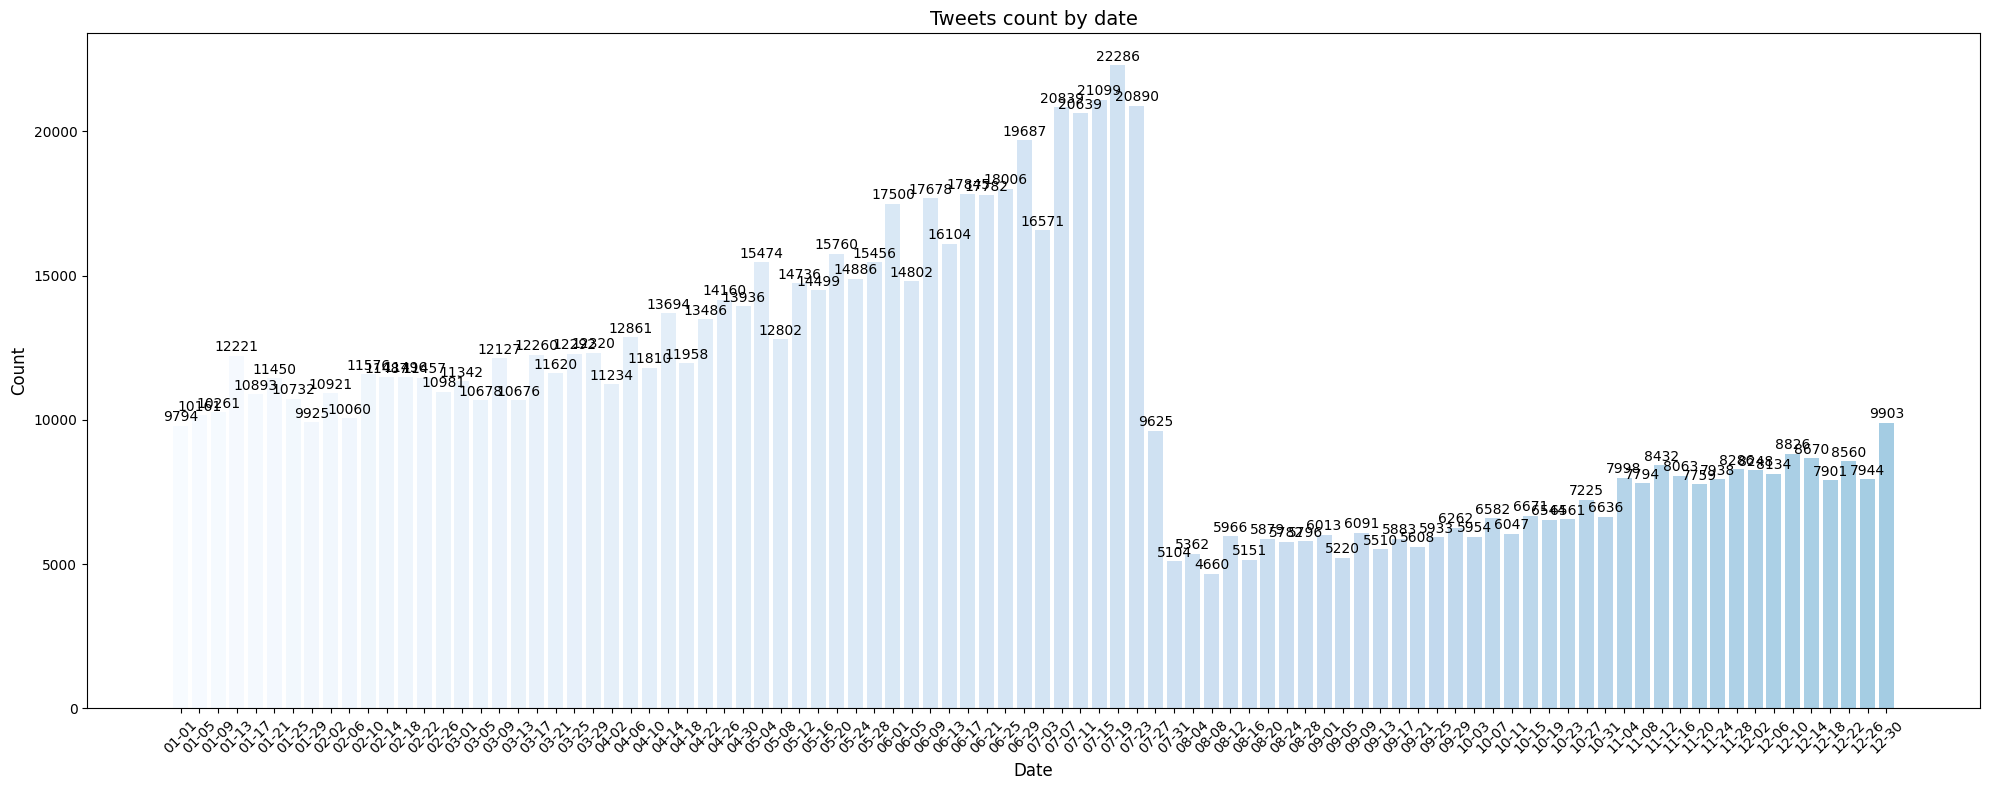

In [55]:
import matplotlib.pyplot as plt

sampling_interval = 4
df_sampled = tweets_per_day.iloc[::sampling_interval]

plt.figure(figsize=(20,8))
bars = plt.bar(df_sampled['day'],df_sampled["counts"],color=plt.cm.Blues(range(len(df_sampled))))

plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Tweets count by date',fontsize=14)

plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2,yval+50,yval,ha='center',va='bottom')

plt.tight_layout()
plt.show()

## Top 10 Source platforms for tweets

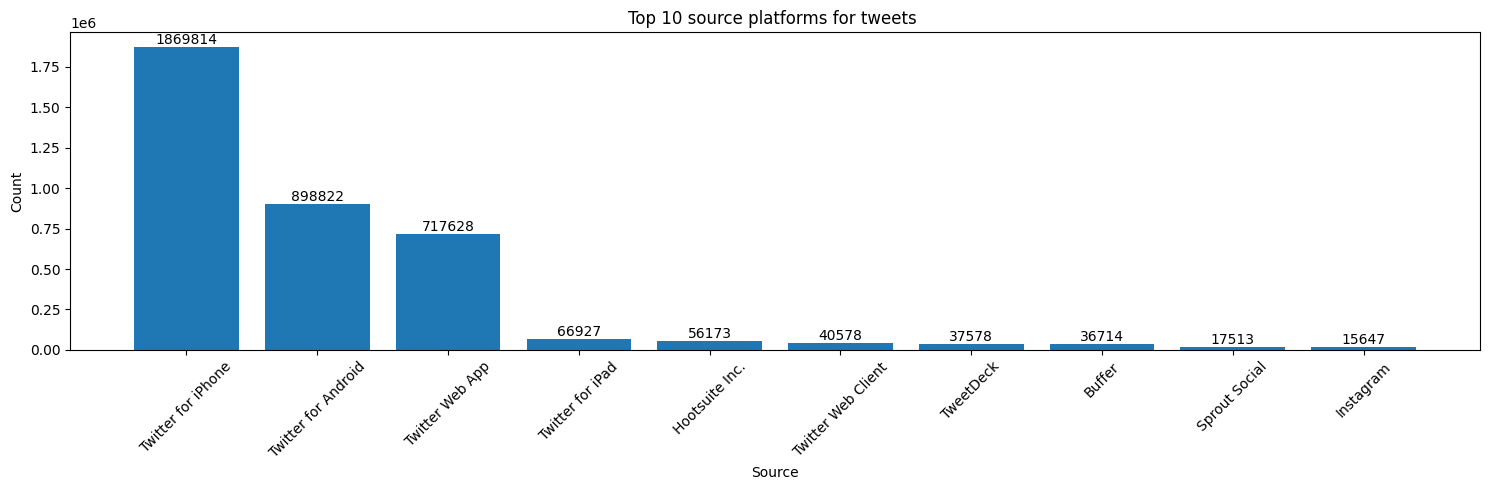

In [75]:
tweet_per_source = df['tweet_source'].value_counts().reset_index(name='counts')

tweet_per_source_10 = tweet_per_source.iloc[:10]
plt.figure(figsize=(15,5))
bars = plt.bar(tweet_per_source_10['tweet_source'],tweet_per_source_10['counts'])

plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Top 10 source platforms for tweets ')

plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2,yval+50,yval,ha='center',va='bottom')

plt.tight_layout()
plt.show()

In [4]:
df['tweet_source'].value_counts()

tweet_source
Twitter for iPhone     1869814
Twitter for Android     898822
Twitter Web App         717628
Twitter for iPad         66927
Hootsuite Inc.           56173
                        ...   
Who is visits??              1
erased21720457               1
Phone2Action                 1
erased20622929               1
Seesmic                      1
Name: count, Length: 457, dtype: int64

In [ ]:
# df_1 = df[df['tweet_source'].isin(['Twitter for iPhone','Twitter for Android'])]
# df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2768636 entries, 0 to 215011
Data columns (total 12 columns):
 #   Column                Dtype         
---  ------                -----         
 0   class                 object        
 1   tweet_id              int64         
 2   day                   datetime64[ns]
 3   time                  object        
 4   tweet                 object        
 5   clean_tweet           object        
 6   tweet_favorite_count  int64         
 7   tweet_retweet_count   int64         
 8   tweet_source          object        
 9   user_id               int64         
 10  user_followers_count  int64         
 11  user_friends_count    int64         
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 274.6+ MB


In [ ]:
# df_1['class'].value_counts()

class
CONTROL       1613538
ADHD           743029
DEPRESSION     254195
BIPOLAR        157874
Name: count, dtype: int64

In [ ]:
# df = df_1[['class','tweet']]


In [53]:
df.head(100)

,class,tweet
0,ADHD,"""CRIED WHEN THEY PLAY THE NATIONAL ANTHEM HTTP..."
1,ADHD,"""@USER its so wild seeing these kinds of posts..."
2,ADHD,"""now give us a joint album HTTPURL"""
3,ADHD,"""no more crinkle cut fries"""
4,ADHD,"""i dont understand this wave of ppl being crue..."
...,...,...
116,ADHD,"""Wild Saturday night of cherry pitting. Hoping..."
117,ADHD,"""@USER I currently have many, many photos on m..."
118,ADHD,"""I love a baby laugh. These two are both gonna..."
119,ADHD,"""Im getting these made as matching T-shirts fo..."


In [55]:
print(f'Duplicate rows: {df.duplicated().sum()}')

df.drop_duplicates(subset='tweet',inplace=True)

Duplicate rows: 0


/var/folders/hw/0mhbk5ds3899rhvr34p9j0qr0000gp/T/ipykernel_22478/1887542892.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='tweet',inplace=True)


## Lowercase;Remove URLS, Mentions,Hashtags, Punctuation, Special Characters, Numbers, Extra Whitespace and Stop words

In [5]:
import re
import emoji
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk

def strip_emoji(text):
    return ''.join(char for char in text if not emoji.is_emoji(char))

def strip_all_entities(text):
    text = text.replace('\r','').replace('\n',' ').replace('\n',' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+","", text)
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    banned_list = string.punctuation+'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('','',banned_list)
    text = text.translate(table)
    return text

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text):
    return re.sub("\s\s+"," ",text)

# Ensure NLTK resources are downloaded
# nltk.download('stopwords')
# nltk.download('wordnet')




def preprocess_tweet(text):
    return remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(text)))))

# Example usage
tweet = "I.  love NLP! 😊 Check this out: https://example.com @user #NLP #MachineLearning"
processed_tweet = preprocess_tweet(tweet)
print(processed_tweet)


i love nlp check this out nlp machinelearning


In [6]:
df['tweet'] = df['tweet'].apply(preprocess_tweet)
df.head()

,class,tweet_id,day,time,tweet,clean_tweet,tweet_favorite_count,tweet_retweet_count,tweet_source,user_id,user_followers_count,user_friends_count
0,ADHD,1551603204693102594,2022-07-25,16:20:06,cried when they play the national anthem httpurl,'CRIED WHEN THEY PLAY THE NATIONAL ANTHEM HTTP...,1,0,Twitter for iPhone,746283290,2023,952
1,ADHD,1551286875251527680,2022-07-24,19:23:07,its so wild seeing these kinds of posts cause ...,'@usuario its so wild seeing these kinds of po...,0,0,Twitter for iPhone,746283290,2023,952
2,ADHD,1550315143761993728,2022-07-22,03:01:48,now give us a joint album httpurl,'now give us a joint album HTTPURL',1,0,Twitter for iPhone,746283290,2023,952
3,ADHD,1549572260780036098,2022-07-20,01:49:51,no more crinkle cut fries,'no more crinkle cut fries',0,0,Twitter for iPhone,746283290,2023,952
4,ADHD,1549303151467036678,2022-07-19,08:00:30,i dont understand this wave of ppl being cruel...,'i dont understand this wave of ppl being crue...,13,1,Twitter for iPhone,746283290,2023,952


In [7]:
df['tweet'] = df['tweet'].astype(str)

In [8]:
df = df[['class','tweet']]

In [10]:
df['class'].value_counts()

class
CONTROL       2499293
ADHD           975609
DEPRESSION     318463
BIPOLAR        192217
Name: count, dtype: int64

In [11]:
# print(f'Duplicate rows: {df.duplicated().sum()}')
df.drop_duplicates(subset='tweet', inplace= True)

In [12]:
df['class'].value_counts()

class
CONTROL       2368205
ADHD           938411
DEPRESSION     299264
BIPOLAR        182706
Name: count, dtype: int64

## remove words of tweet that are less than 5 words and more than 30 words

In [13]:
def word_count(text):
    if isinstance(text,str):
        return len(text.split())
    return 0

df['text_len'] = df['tweet'].apply(word_count)

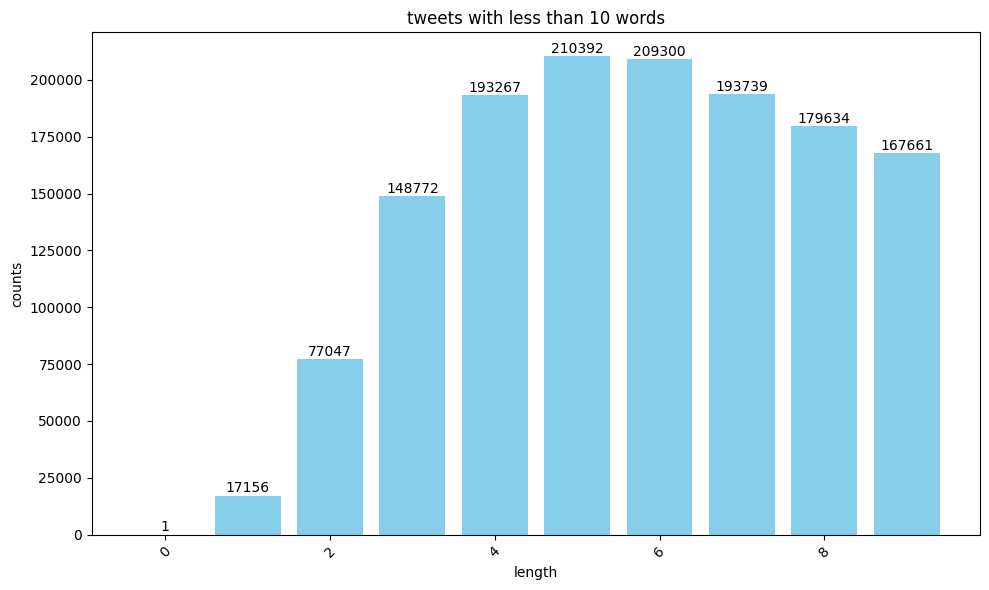

In [14]:
import matplotlib.pyplot as plt
text_num = df['text_len'].value_counts().reset_index(name='counts')

df_filtered = text_num[text_num['text_len']<10]

plt.figure(figsize=(10,6))
bars =plt.bar(df_filtered['text_len'], df_filtered['counts'], color='skyblue')

plt.xlabel('length')
plt.ylabel('counts')
plt.title('tweets with less than 10 words')
plt.xticks(rotation=45)
plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2,yval+50,yval,ha='center',va='bottom')
plt.show()


In [15]:
df = df[df['text_len']>4]

In [16]:
empty_strings = (df == '')
print(df[empty_strings.any(axis=1)].value_counts())
print(df[empty_strings.any(axis=1)])

Series([], Name: count, dtype: int64)
Empty DataFrame
Columns: [class, tweet, text_len]
Index: []


In [17]:
print(f'Duplicate rows: {df.duplicated().sum()}')
# df = df.drop_duplicates()

Duplicate rows: 0


In [18]:
df.sample(10)

,class,tweet,text_len
160172,CONTROL,too bad i still hate him for stupid suspension...,14
84875,CONTROL,that man is never known for using logic in any...,13
13983,ADHD,1 referring to a war long after mikasa died 2 ...,37
195894,CONTROL,it makes perfect sense he thinks he is holding...,41
152186,CONTROL,were offering the first dose of the pfizer vac...,31
70264,CONTROL,in part 2 of episode 8 of omegamatters dr bill...,34
146602,CONTROL,i changed it to celcius just for you i cant be...,40
101447,DEPRESSION,all the issues at dover are basically because ...,26
98156,CONTROL,no we wont factsmatter i dont even remember th...,44
155580,CONTROL,using covid as an excise to control everything,8


## random sampling 2500 of each class

In [19]:
samples_per_class = 20000

stratified_sample_df = df.groupby('class').apply(lambda x:x.sample(n=samples_per_class)).reset_index(drop=True)

/var/folders/hw/0mhbk5ds3899rhvr34p9j0qr0000gp/T/ipykernel_31371/1863818402.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample_df = df.groupby('class').apply(lambda x:x.sample(n=samples_per_class)).reset_index(drop=True)


In [20]:
stratified_sample_df['class'].value_counts()

class
ADHD          20000
BIPOLAR       20000
CONTROL       20000
DEPRESSION    20000
Name: count, dtype: int64

In [21]:
stratified_sample_df = stratified_sample_df.drop(columns=['text_len'])

In [22]:
stratified_sample_df.to_csv('cleaned_tweet_80k.csv', index=False)